# Multipole field component in MU63

In [2]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt 
from matplotlib import cm
from functools import partial
from multiprocessing import Pool
from scipy import stats
import numpy as np
import scipy.optimize
import gc #Garbage collector
import glob
from pybt.myjson.encoder import myJSONDecoder
import sys  
sys.path.insert(0, '/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction')
plt.style.use('default')
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
from functions import *

/tmp/eljohnso/ipykernel_5033/4195600372.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Image


In [3]:
import importlib
import sys
importlib.reload(sys.modules['functions']) # Can be deleted - useful if modifications made to function file and not wanting to reload the whole notebook
from functions import *
from madx_functions import *

In [4]:
# settings for MADX
gamma = 25.598474067 # Previously obtained by: header_read, twiss_read = read_twiss_file('tfs/fast_extraction.twiss')
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
momentum = 24 # beam momentum (GeV/c)
Brho = momentum*3.3356

In [5]:
img = plt.imread("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/mu63_background_removed.png")

In [6]:
MU_type= "T"
fieldmap = read_and_interpolate_fieldmap(MU_type,24)
interp_fieldmap = atr.interpolate_fieldmap(fieldmap)

reading field map T type: 4642A/MUT_4642_xy_grid.table
flipping signs of B-fields


In [7]:
############################### Stray field calculation ###############################
# Calculate the trajectories
# input angle and position of the beam in the global reference system
particle = 'proton'       # particle name: 'proton' or 'carbon12'
PS_radius = 70.079
subtending_angle = (2*np.pi/100)
sagitta = PS_radius*(1-np.cos(subtending_angle/2))
chord = PS_radius*2*np.sin(subtending_angle/2)

extraction_offset = 0.3 # Roughly 13 cm
extraction_angle = 0.04 # 0.8 deg
x_offset = + extraction_offset*np.cos(subtending_angle/2)
z_offset = + extraction_offset*np.sin(subtending_angle/2)

track_end_z_m = chord/2 # approximate location in longitudinal direction of the magnet at where to stop the tracking 

ang_glob = (subtending_angle/2 + extraction_angle, 0.0)
pos_glob = (-sagitta+x_offset,  0.0, -(chord/2+z_offset))

# Create particles
setGen = atr.SetGenerator(particle)
distr_part_ref = {'dX': 0, 'dXP': 0, 'dY': 0, 'dYP': 0, 'dS': 0, 'en_MeV': momentum_to_energy(momentum)*1000, 'dt': 0} # Distribution of the reference particle in local coordinate system | kinetic energy of the beam in MeV
set13_local = setGen.get_part13_local(distr_part_ref, dX=1e-3, dXP=1e-3, dY=1e-3, dYP=1e-3, dt=4e-12, dD=1e-3) # set of distributions for 13 particles in local coordinate system
set13_global = setGen.get_partset_global(set_local=set13_local, pos_glob0=pos_glob, ang_glob0=ang_glob) # set of distributions for 13 particles in global coordinate system to be used for tracking

# run reference particle to determine the tracking-end line for the entire set
plane_ref = trackend_plane(interp_fieldmap, particle, set13_global[0], track_end_z_m)
def track_is_inside(x ,p , t, a=plane_ref[0], b=plane_ref[1], c=plane_ref[2], d=plane_ref[3]):
    return x[2] < -(a * x[0] + b * x[1] + d  ) / c

# Deletes the file content if it wasn't empty
f = open("/eos/user/e/eljohnso/SWAN_projects/btp_stray_elements/B-field/field.txt", "w")
f.write(f"") 
f.close()

# run only particle 0
input_zip = [set13_global[0]+(track_is_inside,)]
with Pool(6) as p:
    partial_track_one_particle = partial(track_one_particle, interp_fieldmap, particle) # We provide a subset of variables\n",
    tracks_set = p.map(partial_track_one_particle, input_zip)
tracks1 = atr.Tracks(tracks_set, particle)

track_z = tracks1.tracks_set[0]["z"]
track_x = tracks1.tracks_set[0]["x"]

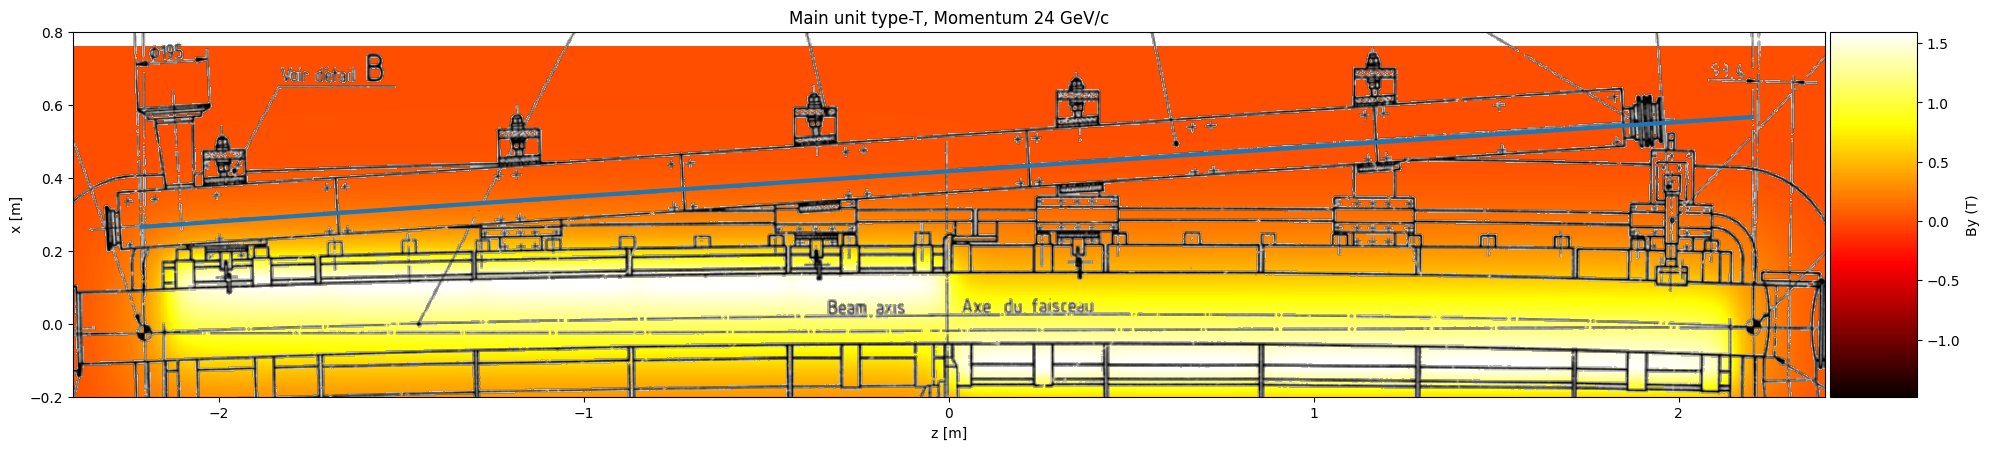

In [8]:
############################### Plotting ###############################
fig, ax = plt.subplots(figsize=(20, 8), tight_layout = True)
ax.plot(tracks1.tracks_set[0]["z"],tracks1.tracks_set[0]["x"], lw=3, label = f"Particle tracking")
plot_fieldmap_faster(fig, ax, fieldmap, "By", 'y',"z","x",0.0)
plot_background(fig, ax, img, (269,421), (1659,414))
ax.set_title(f"Main unit type-{MU_type}, Momentum {momentum} GeV/c")
ax.set_xlim(-2.4,2.4)
ax.set_ylim(-0.2,0.8)
plt.savefig("fig/mfc_mu62_track.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

# We probe the field transversly

Multipole field component with deflection: (0.153, -1.367, 2.686, 1.698)
Multipole field component with deflection: (0.164, -1.499, 3.672, -3.813)
Multipole field component with deflection: (0.174, -1.644, 4.905, -11.485)
Multipole field component with deflection: (0.185, -1.795, 6.306, -21.57)
Multipole field component with deflection: (0.195, -1.951, 7.968, -35.626)
Multipole field component with deflection: (0.204, -2.107, 9.681, -50.49)
Multipole field component with deflection: (0.213, -2.255, 11.363, -66.644)
Multipole field component with deflection: (0.221, -2.393, 12.974, -80.367)
Multipole field component with deflection: (0.228, -2.514, 14.29, -91.261)
Multipole field component with deflection: (0.234, -2.615, 15.286, -97.946)
Multipole field component with deflection: (0.238, -2.696, 15.885, -98.079)
Multipole field component with deflection: (0.242, -2.75, 16.186, -99.012)
Multipole field component with deflection: (0.245, -2.791, 16.384, -96.459)
Multipole field component

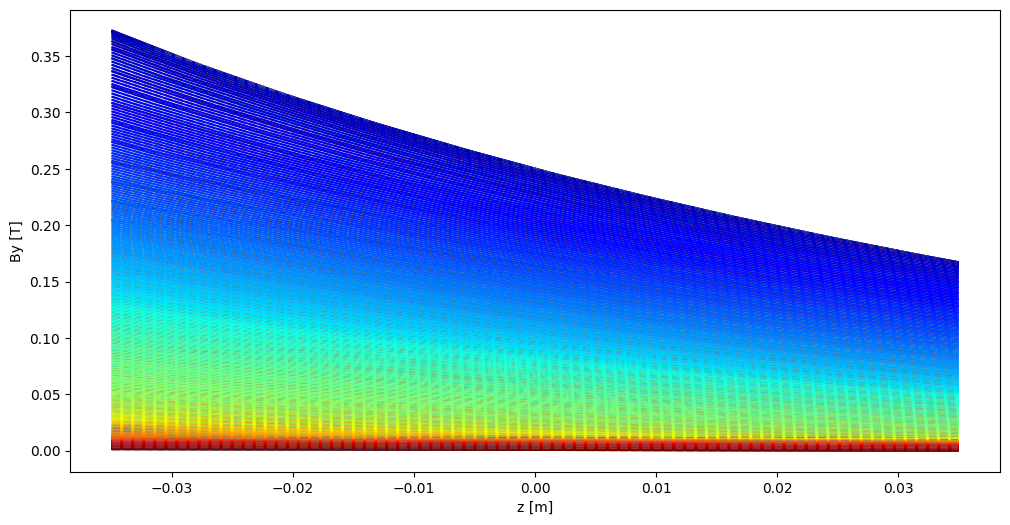

In [9]:
#we probe the field transversly

fig, ax = plt.subplots(figsize=(12,6))

zeroth_order_da = []
first_order_da = []
second_order_da = []
third_order_da = []

subset=1
colors = plt.cm.jet(np.linspace(0,1,int(len(track_x)/subset)))
for i in range(int(len(track_x)/subset)):

    x_list = []
    By_list = []

    center_x = track_x[int(i*subset)]
    probing_range = 0.035 # in meters
    transverse_range = np.linspace(-probing_range,probing_range,100)

    if i>0:
        deflection_angle=-np.arctan( (track_x[i*subset]-track_x[i*subset-1*subset])/(track_z[i*subset]-track_z[i*subset-1*subset]) ) #rad
    else:
        deflection_angle = -ang_glob[0]
    
    for offset in (transverse_range):
        By =  interp_fieldmap["By"]([center_x + offset*np.cos(deflection_angle),0,track_z[int(i*subset)]+offset*np.sin(deflection_angle)])[0]
        x = offset*np.cos(deflection_angle)
        x_list.append(x)
        By_list.append(By)
        
    # Polynomial fit
    x_list = np.array(x_list)
    poly_fit = np.polyfit(x_list, By_list, 3)
    ax.plot(x_list, poly_fit[-1]+poly_fit[-2]*x_list+poly_fit[-3]*x_list**2+poly_fit[-4]*x_list**3, linestyle="--")

    print (f"Multipole field component with deflection: {round(poly_fit[-1],3), round(poly_fit[-2],3), round(poly_fit[-3],3), round(poly_fit[-4],3)}")

    zeroth_order_da.append(poly_fit[-1]/Brho)
    first_order_da.append(poly_fit[-2]/Brho)
    second_order_da.append(poly_fit[-3]/Brho)
    third_order_da.append(poly_fit[-4]/Brho)
        
    ax.plot(x_list, By_list, color=colors[i], label=f"z = {round(track_z[int(i*subset)],3)} [m]\nMFC: {round(poly_fit[-1],3), round(poly_fit[-2],3), round(poly_fit[-3],3), round(poly_fit[-4],3)}")
    
ax.set_xlabel("z [m]")
ax.set_ylabel("By [T]")
# ax.legend()
plt.savefig("fig/mfc_mu62_polifit.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

In [10]:
zeroth_order_da = np.array(zeroth_order_da)
first_order_da = np.array(first_order_da)
second_order_da = np.array(second_order_da)
third_order_da = np.array(third_order_da)

In [11]:
# List that computes the s distance along the track
track_s = []
track_s.append(0)
old_hypothenus = 0
for i in range(int(len(track_x)/subset)-1):
    z = (track_z[i+1]-track_z[i])**2
    x = (track_x[i+1]-track_x[i])**2
    hypothenus = np.sqrt(z + x)
    s = hypothenus+old_hypothenus
    track_s.append(s)
    old_hypothenus = s
tracks_s = np.array(track_s)

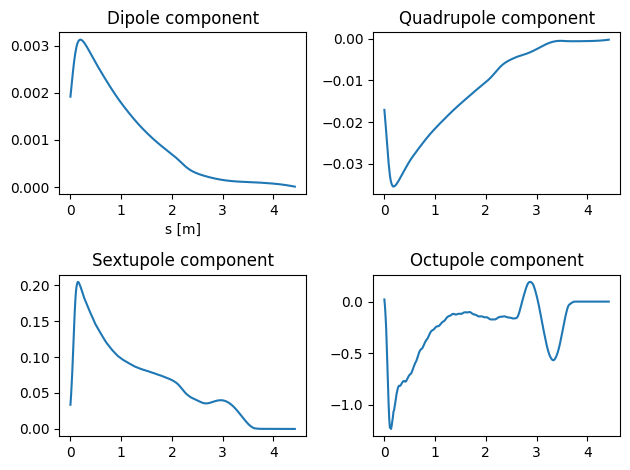

In [12]:
fig, ax = plt.subplots(2,2, tight_layout=True)
ax[0,0].plot(np.array(track_s), zeroth_order_da, label="MFC model")

ax[0,1].plot(np.array(track_s), first_order_da, label="MFC model")

ax[1,0].plot(np.array(track_s), second_order_da, label="MFC model")

ax[1,1].plot(np.array(track_s), third_order_da, label="MFC model")

ax[0,0].set_title("Dipole component")
ax[0,0].set_xlabel("s [m]")

ax[0,1].set_title("Quadrupole component")
ax[0,0].set_xlabel("s [m]")

ax[1,0].set_title("Sextupole component")
ax[0,0].set_xlabel("s [m]")

ax[1,1].set_title("Octupole component")
ax[0,0].set_xlabel("s [m]")

plt.savefig("fig/mfc_mu62_4_components.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

Text(0.5, 0, 's [m]')

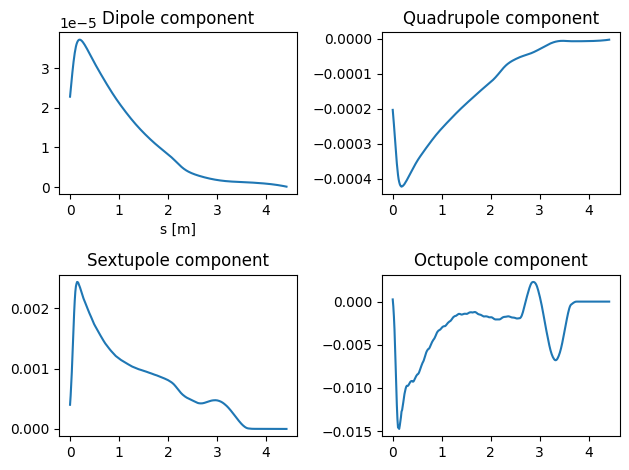

In [13]:
# Normalised with the length for export to MAD-X
zeroth_order_dan = zeroth_order_da*(track_s[-1]/len(track_s))
first_order_dan = first_order_da*(track_s[-1]/len(track_s))
second_order_dan = second_order_da*(track_s[-1]/len(track_s))
third_order_dan = third_order_da*(track_s[-1]/len(track_s))

fig, ax = plt.subplots(2,2, tight_layout=True)
ax[0,0].plot(np.array(track_s), zeroth_order_dan, label="MFC model")

ax[0,1].plot(np.array(track_s), first_order_dan, label="MFC model")

ax[1,0].plot(np.array(track_s), second_order_dan, label="MFC model")

ax[1,1].plot(np.array(track_s), third_order_dan, label="MFC model")

ax[0,0].set_title("Dipole component")
ax[0,0].set_xlabel("s [m]")

ax[0,1].set_title("Quadrupole component")
ax[0,0].set_xlabel("s [m]")

ax[1,0].set_title("Sextupole component")
ax[0,0].set_xlabel("s [m]")

ax[1,1].set_title("Octupole component")
ax[0,0].set_xlabel("s [m]")

# plt.savefig("fig/mfc_mu62_4_components.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

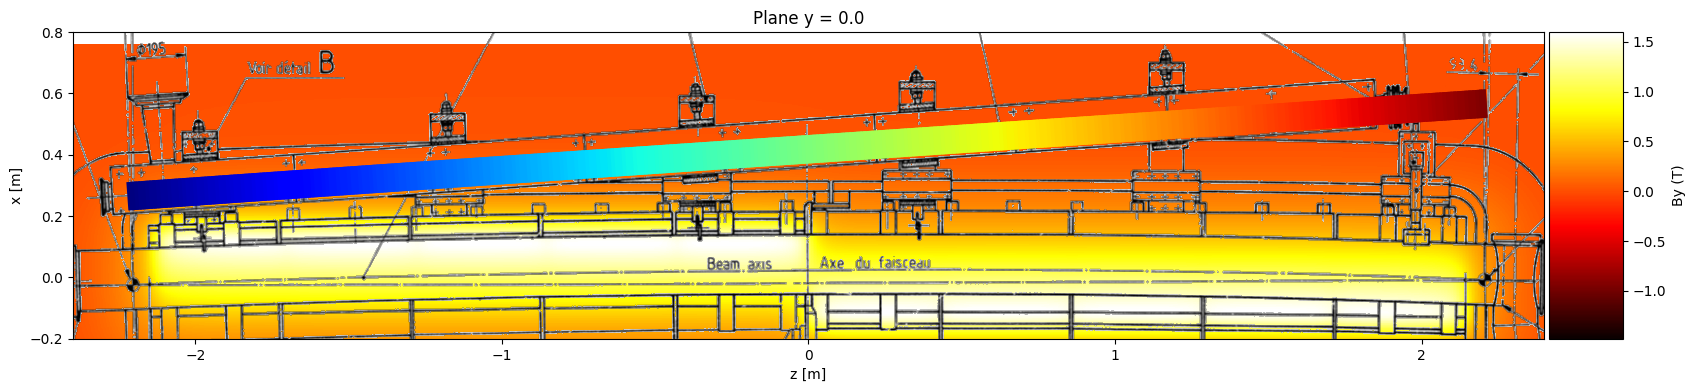

In [14]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tracks1.tracks_set[0]["z"], tracks1.tracks_set[0]["x"], color="b")

plot_fieldmap_faster(fig, ax, fieldmap, "By", 'y',"z","x",0.0)

colors = plt.cm.jet(np.linspace(0,1,int(len(track_x)/subset)))
for i in range(int(len(track_z)/subset)):
    
    center_x = track_x[i*subset]
    
    if i>0:
        deflection_angle=-np.arctan( (track_x[i*subset]-track_x[i*subset-1*subset])/(track_z[i*subset]-track_z[i*subset-1*subset]) ) #rad
    else:
        deflection_angle = -ang_glob[0]
    
    x_probing_list = []
    z_probing_list = []
    
    for offset in (transverse_range):
        By =  interp_fieldmap["By"]([center_x + offset*np.cos(deflection_angle) ,0,track_z[i*subset]+offset*np.sin(deflection_angle)])[0]
        x_probing_list.append(center_x + offset*np.cos(deflection_angle))
        z_probing_list.append(track_z[i*subset]+offset*np.sin(deflection_angle))
        By_list.append(By)
    ax.plot(z_probing_list,x_probing_list, color=colors[i], lw=5)

ax.set_aspect("equal")
plot_background(fig, ax, img, (269,421), (1659,414))
ax.set_xlim(-2.4,2.4)
ax.set_ylim(-0.2,0.8)

plt.savefig("fig/mfc_mu62_track_with_probing.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

# Export the MFC to a file

The format for the .ele file is as follows:
``` python
stray1 : multipole,knl:={2.11E-07,-3.11E-06,5.25E-05,-0.001056026};
stray2 : multipole,knl:={2.78E-07,-4.03E-06,6.74E-05,-0.001303161};
stray3 : multipole,knl:={3.54E-07,-5.09E-06,8.47E-05,-0.001548501};
```

In [15]:
f = open("strayMU63.seq", "w")
for i in range(len(tracks_s)):
    f.write("stray"+str(i)+" at = "+str(track_s[i])+";")
    f.write("\n")
f.close()

The format for the .seq file is a follows:

``` python
stray1, at = 29.93606067;
stray2, at = 29.95606067;
stray3, at = 29.97606067;
```


In [16]:
f = open("strayMU63.ele", "w")
for i in range(len(zeroth_order_da)):
    f.write("stray"+str(i)+" : multipole, knl:= "+str(zeroth_order_dan[i])+" , "+str(first_order_dan[i])+" , "+str(second_order_dan[i])+" , "+str(third_order_dan[i])+";")
    f.write("\n")
f.close()

# Check if we can remake the plots from the files

In [17]:
s = []
with open("strayMU63.seq", "r") as f:
    for l in f:
        sp = l.split()
        s.append(float(sp[3][:-1]))

In [18]:
zeroth = []
first = []
second = []
third = []
with open("strayMU63.ele", "r") as f:
    for l in f:
        sp = l.split()
        zeroth.append(float(sp[4]))
        first.append(float(sp[6]))
        second.append(float(sp[8]))
        third.append(float(sp[10][:-1]))

In [19]:
zeroth

[2.2845168721284582e-05,
 2.4418343785524915e-05,
 2.5980632498901695e-05,
 2.7508142953342247e-05,
 2.8980813884851685e-05,
 3.037591029728956e-05,
 3.168057557911589e-05,
 3.2844268822291426e-05,
 3.388459677525281e-05,
 3.4768415886488425e-05,
 3.550452868528824e-05,
 3.608564490736681e-05,
 3.651408486947604e-05,
 3.684531023543851e-05,
 3.706109329080871e-05,
 3.7205613203109296e-05,
 3.7254504597334144e-05,
 3.724719201182313e-05,
 3.719156685690546e-05,
 3.708888078390713e-05,
 3.6960111189252696e-05,
 3.679442944124152e-05,
 3.660823639437121e-05,
 3.640352887233081e-05,
 3.6180137807555456e-05,
 3.5947017702181646e-05,
 3.569979177292691e-05,
 3.544548695278583e-05,
 3.5184585627342485e-05,
 3.491697051849955e-05,
 3.4646505449801723e-05,
 3.437088470525134e-05,
 3.409280686975647e-05,
 3.3812260585130596e-05,
 3.3529393879793666e-05,
 3.324668676415279e-05,
 3.296354740307786e-05,
 3.2681317566248865e-05,
 3.240026561119001e-05,
 3.2120806811344544e-05,
 3.184341081519584e-05

Text(0.5, 0, 's [m]')

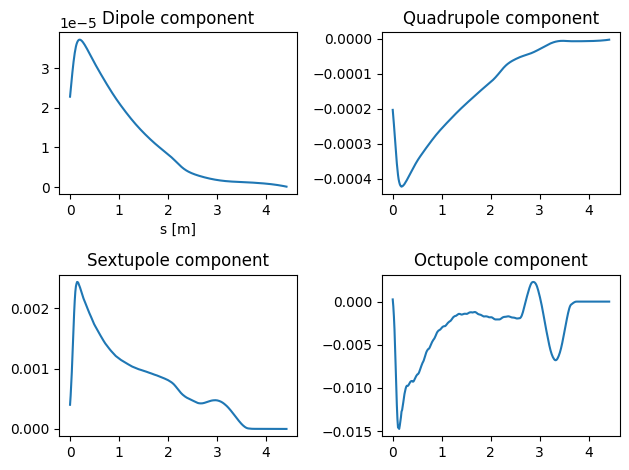

In [20]:
fig, ax = plt.subplots(2,2, tight_layout=True)
ax[0,0].plot(np.array(s), zeroth, label="MFC model")

ax[0,1].plot(np.array(s), first, label="MFC model")

ax[1,0].plot(np.array(s), second, label="MFC model")

ax[1,1].plot(np.array(s), third, label="MFC model")

ax[0,0].set_title("Dipole component")
ax[0,0].set_xlabel("s [m]")

ax[0,1].set_title("Quadrupole component")
ax[0,0].set_xlabel("s [m]")

ax[1,0].set_title("Sextupole component")
ax[0,0].set_xlabel("s [m]")

ax[1,1].set_title("Octupole component")
ax[0,0].set_xlabel("s [m]")

# Write the files in the folder for the dump line with stray

In [33]:
offset = 0.45
MU62_length = 4.408794008890941

f = open("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/f61d_with_stray/strayMU63.seq", "w")
for i in range(len(tracks_s)):
    f.write("collMU63_"+str(i)+": COLLIMATOR, at = "+str(track_s[i]+ MU62_length + offset + 0.87287 + offset)+", L=0.0, APERTYPE=RECTANGLE, APERTURE={0.035, 0.011};\n")
    f.write("strayMU63_"+str(i)+" at = "+str(track_s[i] + MU62_length + offset + 0.87287 + offset)+";")
    f.write("\n")
f.close()

f = open("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/f61d_with_stray/strayMU63.ele", "w")
for i in range(len(zeroth_order_da)):
    f.write("strayMU63_"+str(i)+" : multipole, knl:= "+str(zeroth_order_dan[i])+" , "+str(first_order_dan[i])+" , "+str(second_order_dan[i])+" , "+str(third_order_dan[i])+";")
    f.write("\n")
f.close()

In [31]:
offset = 0.45
MU62_length = 4.408794008890941

track_s[0] + MU62_length + offset + 0.87287 + offset

6.181664008890941

In [35]:
MU62_length + offset + 0.87287

5.731664008890941